In [1]:
# import library
import os
import pandas as pd
pd.set_option('display.max_rows', None)
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from numpy import arange
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold

import pandas as pd
import numpy as np
import pickle
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

In [2]:
# import data 
df = pd.read_csv('/Users/ngocnguyen/Dropbox/Mac/Desktop/SQL/listing_cleaned.csv')

In [3]:
df.head()

,host_location,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,...,identity_manual,phone,government_id,kba,photographer,reviews,work_email,sesame_offline,manual_offline,weibo
0,"London, England, United Kingdom",0,3.0,3.0,1,1,Islington,51.56861,-0.11270,Private room in rental unit,...,0,1,1,0,0,1,0,0,0,0
1,"Kensington, England, United Kingdom",0,1.0,1.0,1,1,Kensington and Chelsea,51.48780,-0.16813,Entire rental unit,...,0,1,1,0,0,1,0,0,0,0
2,"London, England, United Kingdom",0,3.0,3.0,1,1,Hammersmith and Fulham,51.47935,-0.19743,Private room in townhouse,...,1,1,1,0,0,0,1,0,0,0
3,"Isleworth, England, United Kingdom",0,2.0,2.0,1,1,Hounslow,51.46416,-0.32554,Private room in residential home,...,0,1,1,0,0,1,0,0,0,0
4,"Richmond, England, United Kingdom",0,1.0,1.0,1,1,Richmond upon Thames,51.48085,-0.28086,Entire townhouse,...,0,1,1,0,0,1,1,0,0,0


In [4]:
# Dependent variable
var_dep = ['price']

# Categorical variables
vars_category = [var for var in df.columns if df[var].dtype != 'float' and df[var].dtype != 'int']

# Numerical variables
vars_numeric = [var for var in df.columns if var not in var_dep + vars_category]

# Indepedent variables
vars_ind = vars_category + vars_numeric



In [5]:
# label categorical variable
for col in vars_category:
    le = preprocessing.LabelEncoder()
    le.fit(df[col].values)
    df[col]= le.transform(df[col].values)
    
for col in vars_category:
    df[col] = df[col].astype(int)

df[vars_category].head()

,host_location,neighbourhood_cleansed,property_type,room_type,bathrooms_text,has_availability
0,1143,18,50,2,4,1
1,937,19,17,0,2,1
2,1143,12,55,2,3,1
3,894,17,51,2,3,1
4,1569,26,20,0,5,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47379 entries, 0 to 47378
Columns: 2615 entries, host_location to weibo
dtypes: float64(12), int64(2603)
memory usage: 945.3 MB


In [7]:
# split train and test set
X = df[vars_ind]
y = df[var_dep]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [8]:
X_train.shape

(37903, 2614)

In [9]:
y_train.shape

(37903, 1)

## Lasso model

In [10]:
# standarlise data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train[vars_numeric]) 

X_train[vars_numeric] = scaler.transform(X_train[vars_numeric])

X_test[vars_numeric] = scaler.transform(X_test[vars_numeric])

In [11]:
# create function to calculate the accuracy
def fn_MAE(actuals, predictions):
    
    return np.mean(np.abs(predictions - actuals))

def fn_RMSE(actuals, predictions):
    return np.sqrt(np.mean((predictions - actuals)**2))


In [12]:
import time
# recording time
start = time.time()

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
model = LassoCV(alphas=arange(0, 1, 0.01), cv=cv, n_jobs=-1)
# fit model
model.fit(X_train, y_train)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)
end_time = time.time() - start                        # end time of running
print(end_time)

alpha: 0.130000
1144.2608468532562


In [13]:
# fit test set to model
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)
mse_test =mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test,y_pred))
print('MSE test set', round(mse_test, 2))
print('RMSE test set', round(rmse_test, 2))

MSE test set 1253.49
RMSE test set 35.4


In [14]:
# calculate error for the train set
y_pred_train = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('MSE training set', round(mse_train, 2))
print('RMSE training set', round(rmse_train, 2))

MSE training set 1231.29
RMSE training set 35.09


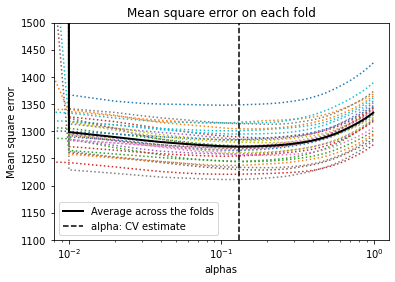

In [15]:
# plot mean square error for each fold
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 1100, 1500
plt.ylim(ymin, ymax);


In [16]:
# coefficient of model
model.coef_

array([ 0.0006344 ,  0.26051053,  0.12274607, ...,  0.00494283,
        0.55547418, -0.09439283])